### Import Packages

In [1]:
from IPython.display import Image, display
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import time
import pickle
import wave, struct
import math
from scipy.fftpack import fft
import scipy
from shutil import copyfile
import pylab
from scipy.io import wavfile
import logging
import random
import PIL.Image
from scipy.ndimage.filters import gaussian_filter
import inception5h
%matplotlib inline
import tensorflow as tf
import librosa

### Define Functions

In [2]:
def load_image(filename):
    image = PIL.Image.open(filename)
    return np.float32(image)

In [3]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [4]:
def plot_image(image):
    # Assume the pixel-values are scaled between 0 and 255.
    
    if False:
        # Convert the pixel-values to the range between 0.0 and 1.0
        image = np.clip(image/255.0, 0.0, 1.0)
        
        # Plot using matplotlib.
        plt.imshow(image, interpolation='lanczos')
        plt.show()
    else:
        # Ensure the pixel-values are between 0 and 255.
        image = np.clip(image, 0.0, 255.0)
        
        # Convert pixels to bytes.
        image = image.astype(np.uint8)

        # Convert to a PIL-image and display it.
        display(PIL.Image.fromarray(image))

In [5]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)
    
    return x_norm

In [6]:
def plot_gradient(gradient):
    # Normalize the gradient so it is between 0.0 and 1.0
    gradient_normalized = normalize_image(gradient)
    
    # Plot the normalized gradient.
    plt.imshow(gradient_normalized, interpolation='bilinear')
    plt.show()

In [7]:
def resize_image(image, size=None, factor=None):
    # If a rescaling-factor is provided then use it.
    if factor is not None:
        # Scale the numpy array's shape for height and width.
        size = np.array(image.shape[0:2]) * factor
        
        # The size is floating-point because it was scaled.
        # PIL requires the size to be integers.
        size = size.astype(int)
    else:
        # Ensure the size has length 2.
        size = size[0:2]
    
    # The height and width is reversed in numpy vs. PIL.
    size = tuple(reversed(size))

    # Ensure the pixel-values are between 0 and 255.
    img = np.clip(image, 0.0, 255.0)
    
    # Convert the pixels to 8-bit bytes.
    img = img.astype(np.uint8)
    
    # Create PIL-object from numpy array.
    img = PIL.Image.fromarray(img)
    
    # Resize the image.
    img_resized = img.resize(size, PIL.Image.LANCZOS)
    
    # Convert 8-bit pixel values back to floating-point.
    img_resized = np.float32(img_resized)

    return img_resized

In [8]:
def get_tile_size(num_pixels, tile_size=400):
    """
    num_pixels is the number of pixels in a dimension of the image.
    tile_size is the desired tile-size.
    """

    # How many times can we repeat a tile of the desired size.
    num_tiles = int(round(num_pixels / tile_size))
    
    # Ensure that there is at least 1 tile.
    num_tiles = max(1, num_tiles)
    
    # The actual tile-size.
    actual_tile_size = math.ceil(num_pixels / num_tiles)
    
    return actual_tile_size

In [9]:
def tiled_gradient(gradient, image, tile_size=400):
    # Allocate an array for the gradient of the entire image.
    grad = np.zeros_like(image)

    # Number of pixels for the x- and y-axes.
    x_max, y_max, _ = image.shape

    # Tile-size for the x-axis.
    x_tile_size = get_tile_size(num_pixels=x_max, tile_size=tile_size)
    # 1/4 of the tile-size.
    x_tile_size4 = x_tile_size // 4

    # Tile-size for the y-axis.
    y_tile_size = get_tile_size(num_pixels=y_max, tile_size=tile_size)
    # 1/4 of the tile-size
    y_tile_size4 = y_tile_size // 4

    # Random start-position for the tiles on the x-axis.
    # The random value is between -3/4 and -1/4 of the tile-size.
    # This is so the border-tiles are at least 1/4 of the tile-size,
    # otherwise the tiles may be too small which creates noisy gradients.
    x_start = random.randint(-3*x_tile_size4, -x_tile_size4)
    while x_start < x_max:
        # End-position for the current tile.
        x_end = x_start + x_tile_size
        
        # Ensure the tile's start- and end-positions are valid.
        x_start_lim = max(x_start, 0)
        x_end_lim = min(x_end, x_max)

        # Random start-position for the tiles on the y-axis.
        # The random value is between -3/4 and -1/4 of the tile-size.
        y_start = random.randint(-3*y_tile_size4, -y_tile_size4)

        while y_start < y_max:
            # End-position for the current tile.
            y_end = y_start + y_tile_size

            # Ensure the tile's start- and end-positions are valid.
            y_start_lim = max(y_start, 0)
            y_end_lim = min(y_end, y_max)

            # Get the image-tile.
            img_tile = image[x_start_lim:x_end_lim,
                             y_start_lim:y_end_lim, :]

            # Create a feed-dict with the image-tile.
            feed_dict = model.create_feed_dict(image=img_tile)

            # Use TensorFlow to calculate the gradient-value.
            g = session.run(gradient, feed_dict=feed_dict)

            # Normalize the gradient for the tile. This is
            # necessary because the tiles may have very different
            # values. Normalizing gives a more coherent gradient.
            g /= (np.std(g) + 1e-8)

            # Store the tile's gradient at the appropriate location.
            grad[x_start_lim:x_end_lim,
                 y_start_lim:y_end_lim, :] = g
            
            # Advance the start-position for the y-axis.
            y_start = y_end

        # Advance the start-position for the x-axis.
        x_start = x_end

    return grad

In [10]:
def optimize_image_save_iters(max_expG,im_file_base,layer_tensor, image,
                   num_iterations=10, step_size=3.0, tile_size=400,
                   show_gradient=False):
    """
    Use gradient ascent to optimize an image so it maximizes the
    mean value of the given layer_tensor.
    
    Parameters:
    layer_tensor: Reference to a tensor that will be maximized.
    image: Input image used as the starting point.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    show_gradient: Plot the gradient in each iteration.
    """

    # Copy the image so we don't overwrite the original image.
    img = image.copy()
    #img_return = image.copy()
    
    #print("Image before:")
    #plot_image(img)

    print("Processing image: ", end="")

    # Use TensorFlow to get the mathematical function for the
    # gradient of the given layer-tensor with regard to the
    # input image. This may cause TensorFlow to add the same
    # math-expressions to the graph each time this function is called.
    # It may use a lot of RAM and could be moved outside the function.
    gradient = model.get_gradient(layer_tensor)
    for i in range(max_expG+1): #range(num_iterations+10):
        # Calculate the value of the gradient.
        # This tells us how to change the image so as to
        # maximize the mean of the given layer-tensor.
        grad = tiled_gradient(gradient=gradient, image=img,
                              tile_size=tile_size)
        
        # Blur the gradient with different amounts and add
        # them together. The blur amount is also increased
        # during the optimization. This was found to give
        # nice, smooth images. You can try and change the formulas.
        # The blur-amount is called sigma (0=no blur, 1=low blur, etc.)
        # We could call gaussian_filter(grad, sigma=(sigma, sigma, 0.0))
        # which would not blur the colour-channel. This tends to
        # give psychadelic / pastel colours in the resulting images.
        # When the colour-channel is also blurred the colours of the
        # input image are mostly retained in the output image.
        sigma = (i * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)

        # Scale the step-size according to the gradient-values.
        # This may not be necessary because the tiled-gradient
        # is already normalized.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        img += grad * step_size_scaled
        
        #filename_pre = 'im' + str(framenum).zfill(5) + '.png'
        
        filename = im_file_base + str(i) + '.pckl'
        
        tmp = open(filename, 'wb')
        pickle.dump(img, tmp)
        tmp.close()
        
        if i == num_iterations-1:
            img_return = img
        
        
        #cv2.imwrite(filename, im_out) 
        
        if show_gradient:
            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size_scaled))

            # Plot the gradient.
            plot_gradient(grad)
        else:
            # Otherwise show a little progress-indicator.
            print(". ", end="")

    print()
    #print("Image after:")
    #plot_image(img)
    
    #return img
    return img_return

In [11]:
def optimize_image(layer_tensor, image,
                   num_iterations=10, step_size=3.0, tile_size=400,
                   show_gradient=False):
    """
    Use gradient ascent to optimize an image so it maximizes the
    mean value of the given layer_tensor.
    
    Parameters:
    layer_tensor: Reference to a tensor that will be maximized.
    image: Input image used as the starting point.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    show_gradient: Plot the gradient in each iteration.
    """

    # Copy the image so we don't overwrite the original image.
    img = image.copy()
    
    #print("Image before:")
    #plot_image(img)

    print("Processing image: ", end="")

    # Use TensorFlow to get the mathematical function for the
    # gradient of the given layer-tensor with regard to the
    # input image. This may cause TensorFlow to add the same
    # math-expressions to the graph each time this function is called.
    # It may use a lot of RAM and could be moved outside the function.
    gradient = model.get_gradient(layer_tensor)
    for i in range(num_iterations):
        # Calculate the value of the gradient.
        # This tells us how to change the image so as to
        # maximize the mean of the given layer-tensor.
        grad = tiled_gradient(gradient=gradient, image=img,
                              tile_size=tile_size)
        
        # Blur the gradient with different amounts and add
        # them together. The blur amount is also increased
        # during the optimization. This was found to give
        # nice, smooth images. You can try and change the formulas.
        # The blur-amount is called sigma (0=no blur, 1=low blur, etc.)
        # We could call gaussian_filter(grad, sigma=(sigma, sigma, 0.0))
        # which would not blur the colour-channel. This tends to
        # give psychadelic / pastel colours in the resulting images.
        # When the colour-channel is also blurred the colours of the
        # input image are mostly retained in the output image.
        sigma = (i * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)

        # Scale the step-size according to the gradient-values.
        # This may not be necessary because the tiled-gradient
        # is already normalized.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        img += grad * step_size_scaled

        if show_gradient:
            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size_scaled))

            # Plot the gradient.
            plot_gradient(grad)
        else:
            # Otherwise show a little progress-indicator.
            print(". ", end="")

    #print()
    #print("Image after:")
    #plot_image(img)
    
    return img

In [12]:
def recursive_optimize_save_iters(max_expG,im_file_base,layer_tensor, image,
                       num_repeats=4, rescale_factor=0.7, blend=0.2,
                       num_iterations=10, step_size=3.0,
                       tile_size=400):
    """
    Recursively blur and downscale the input image.
    Each downscaled image is run through the optimize_image()
    function to amplify the patterns that the Inception model sees.

    Parameters:
    image: Input image used as the starting point.
    rescale_factor: Downscaling factor for the image.
    num_repeats: Number of times to downscale the image.
    blend: Factor for blending the original and processed images.

    Parameters passed to optimize_image():
    layer_tensor: Reference to a tensor that will be maximized.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    """

    # Do a recursive step?
    if num_repeats>0:
        # Blur the input image to prevent artifacts when downscaling.
        # The blur amount is controlled by sigma. Note that the
        # colour-channel is not blurred as it would make the image gray.
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))

        # Downscale the image.
        img_downscaled = resize_image(image=img_blur,
                                      factor=rescale_factor)
            
        # Recursive call to this function.
        # Subtract one from num_repeats and use the downscaled image.
        img_result = recursive_optimize(layer_tensor=layer_tensor,
                                        image=img_downscaled,
                                        num_repeats=num_repeats-1,
                                        rescale_factor=rescale_factor,
                                        blend=blend,
                                        num_iterations=num_iterations,
                                        step_size=step_size,
                                        tile_size=tile_size)
        
        # Upscale the resulting image back to its original size.
        img_upscaled = resize_image(image=img_result, size=image.shape)

        # Blend the original and processed images.
        image = blend * image + (1.0 - blend) * img_upscaled

    print("Recursive level:", num_repeats)
    
     # Process the image using the DeepDream algorithm.
    img_result = optimize_image_save_iters(max_expG,im_file_base,layer_tensor=layer_tensor,
                                image=image,
                                num_iterations=num_iterations,
                                step_size=step_size,
                                tile_size=tile_size)
    
    return img_result

In [13]:
def recursive_optimize(layer_tensor, image,
                       num_repeats=4, rescale_factor=0.7, blend=0.2,
                       num_iterations=10, step_size=3.0,
                       tile_size=400):
    """
    Recursively blur and downscale the input image.
    Each downscaled image is run through the optimize_image()
    function to amplify the patterns that the Inception model sees.

    Parameters:
    image: Input image used as the starting point.
    rescale_factor: Downscaling factor for the image.
    num_repeats: Number of times to downscale the image.
    blend: Factor for blending the original and processed images.

    Parameters passed to optimize_image():
    layer_tensor: Reference to a tensor that will be maximized.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    """

    # Do a recursive step?
    if num_repeats>0:
        # Blur the input image to prevent artifacts when downscaling.
        # The blur amount is controlled by sigma. Note that the
        # colour-channel is not blurred as it would make the image gray.
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))

        # Downscale the image.
        img_downscaled = resize_image(image=img_blur,
                                      factor=rescale_factor)
            
        # Recursive call to this function.
        # Subtract one from num_repeats and use the downscaled image.
        img_result = recursive_optimize(layer_tensor=layer_tensor,
                                        image=img_downscaled,
                                        num_repeats=num_repeats-1,
                                        rescale_factor=rescale_factor,
                                        blend=blend,
                                        num_iterations=num_iterations,
                                        step_size=step_size,
                                        tile_size=tile_size)
        
        # Upscale the resulting image back to its original size.
        img_upscaled = resize_image(image=img_result, size=image.shape)

        # Blend the original and processed images.
        image = blend * image + (1.0 - blend) * img_upscaled

    print("Recursive level:", num_repeats)
    
     # Process the image using the DeepDream algorithm.
    img_result = optimize_image(layer_tensor=layer_tensor,
                                image=image,
                                num_iterations=num_iterations,
                                step_size=step_size,
                                tile_size=tile_size)
    
    return img_result

## Start of Main Code 

In [14]:
inception5h.data_dir = 'inception/5h/'
inception5h.maybe_download()
model = inception5h.Inception5h()
print('Number of layers in neural net: ',len(model.layer_tensors))

Data has apparently already been downloaded and unpacked.
Instructions for updating:
Use tf.gfile.GFile.
Number of layers in neural net:  12


In [15]:
session = tf.InteractiveSession(graph=model.graph)

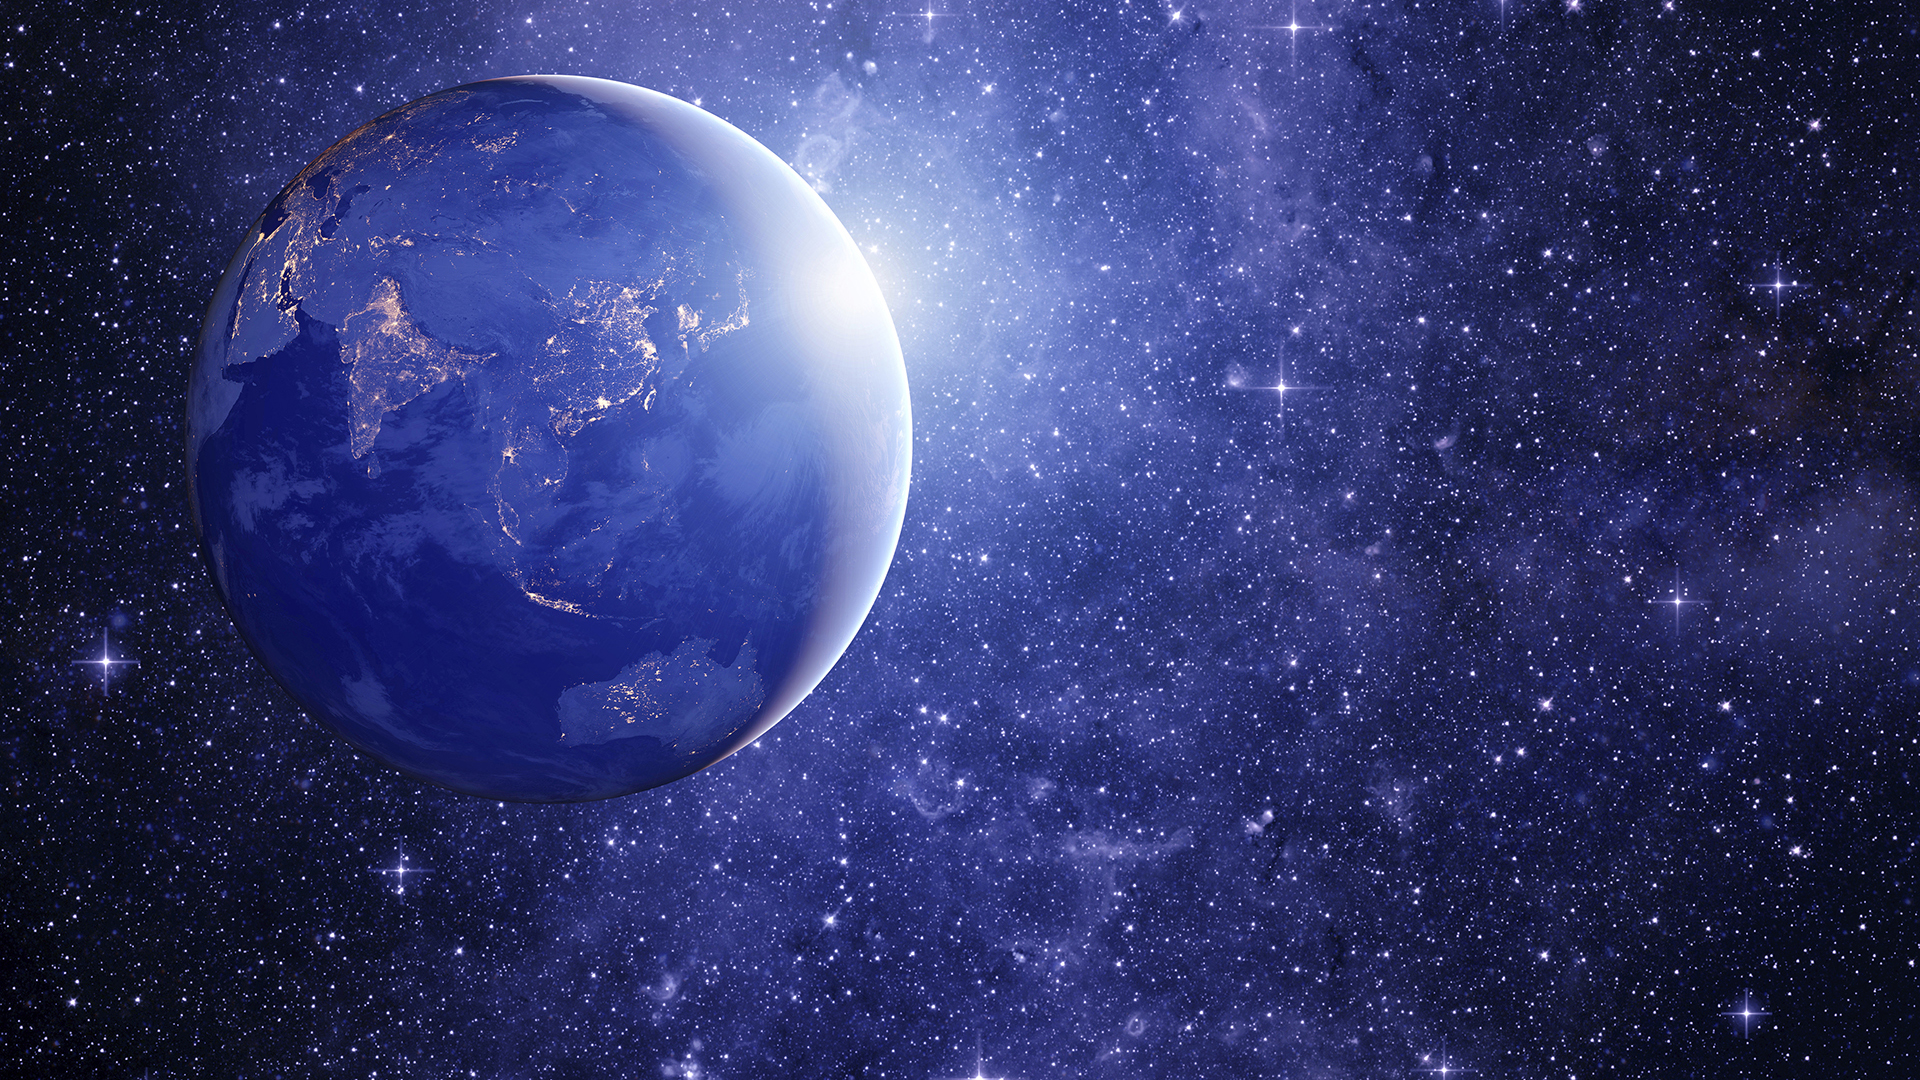

In [16]:
# Load image of interest
#file_im = 'images/Tony_MG_9995s.jpg'
file_im = 'images/Earth_crop2.jpg'
image = load_image(filename=file_im)
plot_image(image)

In [17]:
layer_tensor = model.layer_tensors[2]

In [18]:
def mymkdir(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [ ]:
from shutil import copyfile

In [ ]:
#newpath = 'TTMDemoFiles/'
newpath = 'TTMFull/'
#music_file = 'TTMDemo.wav'
music_file = 'TTM.wav'
vers = '3'
#music_file = 'TTMDemo2.PCM'
#music_file = 'Twisted_final_demo.wav'
newpath_files = newpath + 'Files' + vers + '/'
newpath_ims = newpath + 'im_gen' + vers + '/'
newpath_layers = newpath + 'Ex_layers' + vers + '/'
newpath_layers2 = newpath + 'Ex_layers_all_' + vers + '/'

mymkdir(newpath)
mymkdir(newpath_files)    
mymkdir(newpath_ims)
mymkdir(newpath_layers)
mymkdir(newpath_layers2)
    
# Backup this notebook, so we know exactly which version was used
pyfile = 'DeepDreamViz.ipynb'
destfile = newpath_files + pyfile
copyfile(pyfile,destfile)
    
t0 = -100;
tend = -2000
tint = -.1;
starting_frame = 1
do_bpm = 0;
fps = 30;
bpm = 100;
pi = np.pi
pulseR = 20; #10
pulseG = 20; #25
pulseB = 20; #10
expR = 1.1; #1
expG = 1.1;
expB = .8;  
framefactorG = 1;
framefactorR = 1;
framefactorB = 1;   

do_bass = 1         #(0-120 Hz) bass 
do_highbass = 0     #(120-480Hz) high bass 
do_mids = 0        #(480-2940 Hz) Mids (piano)
do_low_highs = 0    #(2940-7020 Hz) Low Highs 
do_highs = 0        #(7080-22k Hz) Highs 


In [ ]:
fs, frames = librosa.load(music_file, sr=None)
frames

44100

Calculating music file... TTMFull/Files3/TTM30.pckl
Saved music file... TTMFull/Files3/TTM30.pckl
(21095, 11)


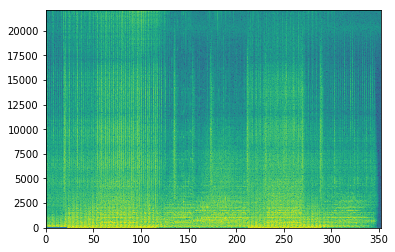

In [ ]:
do_music_load = 1
file_len = len(music_file)        
file_music_pkl = newpath_files + music_file[0:file_len-4] +str(fps) + '.pckl'
if os.path.isfile(file_music_pkl) and do_music_load and 0: 
    print('Loading presaved music file...',file_music_pkl)
    fmusic = open(file_music_pkl, 'rb')
    [Pxx,freqs,t,fs,frames,songFramerate,myNFFT] = pickle.load(fmusic)
    fmusic.close()
else:
    print('Calculating music file...',file_music_pkl)        
    w = wave.open(music_file,'r')
    songFramerate = w.getframerate() #44100
    #fs, frames = wavfile.read(music_file)
    frames,fs  = librosa.load(music_file, sr=None, mono=False)
    #print(np.shape(frames))
    channels = [np.array(frames[0,:]),np.array(frames[ 1,:])]
    #print(channels)
    
    # generate specgram
    myNFFT = np.int(songFramerate/fps) #4096
    Pxx, freqs, t, plot = pylab.specgram(
        channels[0], NFFT=myNFFT,Fs=songFramerate, 
        detrend=pylab.detrend_none, window=pylab.window_hanning,
        noverlap=int(myNFFT * 0.5))
    fmusic = open(file_music_pkl, 'wb')
    pickle.dump([Pxx,freqs,t,fs,frames,songFramerate,myNFFT], fmusic)
    fmusic.close()
    print('Saved music file...',file_music_pkl)

nt = np.size(Pxx,axis=1) #number of timesteps
nf = np.size(Pxx,axis=0) #number of frequencies
maxfs = np.zeros((nt,11));
for i in range(0,nt):
    maxfs[i,0] = t[i]                           #time
    maxfs[i,1] = freqs[np.argmax(Pxx[:,i])]  #Freq w/max vol
    maxfs[i,2] = np.log10(maxfs[i,1])        #log(Freq w/max vol)
    maxfs[i,3] = np.max(Pxx[:,i])            #Max vol
    maxfs[i,4] = np.log10(maxfs[i,3])        #log(Max vol)
    maxfs[i,5] = np.sum(Pxx[0:9,i])          #(0-120 Hz) bass #depends!!! 
    maxfs[i,6] = np.sum(Pxx[3:8,i])          #(120-480Hz) high bass   
    maxfs[i,7] = np.sum(Pxx[9:100,i])         #(480-2940 Hz) Mids 
    maxfs[i,8] = np.sum(Pxx[50:117,i])       #(2940-7020 Hz) Low Highs 
    maxfs[i,9] = np.sum(Pxx[118:367,i])     #(7080-22k Hz) Highs 

maxpeak = np.max(maxfs[:,3])
maxfreq = np.max(maxfs[:,1])

# maxfreqlog = np.log10(maxfreq)
maxfreqlog = np.log10(3000)
maxfs[:,3] = maxfs[:,3]/maxpeak
maxfs[:,4] = maxfs[:,4]/np.log10(maxpeak)
for i in range(5,10):
    maxfs[:,i] = maxfs[:,i]/np.max(maxfs[:,i])
plt.plot(t[1:1300],maxfs[1:1300,5])
print(np.shape(maxfs))

In [ ]:
temp = maxfs[:,5].max()
expG_temp = 1+temp
max_expG = max([1,int(round(expG_temp*20-26,0))])

In [ ]:
framenum = 0; 
vari1=t0  
#layer_tensor = model.layer_tensors[7][:,:,:,0:3]
rand = random.randint(3,11)

while framenum*2+1<maxfs.shape[0]: #vari1 >= tend: #for vari1 in [t0:tint:tend]
    ttemp3 = time.time()

    framenum = framenum+1;  
    isfirst = 0
    bassweight = 1 
    bassweight2 = 0.01
    bassintensity = maxfs[framenum*2,5]
    if maxfs[(framenum-1)*2,5]>bassintensity:
        maxfs[framenum*2,5] = 0.95*maxfs[(framenum-1)*2,5] #.92
        bassintensity = maxfs[framenum*2,5]

    framefactorB = 1-bassweight*bassintensity
    bassval2 = 1-bassweight2*bassintensity                      
    expG = 1+bassweight*bassintensity


    #Mids
    midintensity = maxfs[framenum*2,7]
    if maxfs[(framenum-1)*2,7]>midintensity:
        maxfs[framenum*2,7] = 0.93*maxfs[(framenum-1)*2,7]
        midintensity = maxfs[framenum*2,7]
    elif random.randint(0,2) == 0:
        rand = random.randint(3,11)
        isfirst = 1
    midweight = 0.4
    
    framefactorG = 1-midweight*midintensity

    expG_pre = expG
    #expG = max([1,int(round(expG*20-28,0))])
    
    #new lines
    rand = 8
    expG = max([1,int(round(expG*20-26,0))])
    
    file_dd = newpath_files + 'dd_' + str(rand) + '_' + str(expG) + '.pckl'
    im_file_base = newpath_files + 'dd_' + str(rand) + '_'
    filename = newpath_ims + 'im' + str(framenum).zfill(5) + '.png' 
    filename2 = newpath_layers2 + 'im' + str(rand) + '_' + str(expG) + '.png' 
    
    
    
    save_im_layers = 1
    if os.path.isfile(filename2) == True and save_im_layers:
        copyfile(filename2, filename)
        print(expG_pre, file_dd, filename, ' (copied)')
        continue
        
    print(expG_pre,expG, file_dd, filename)
    
    if os.path.isfile(file_dd):
        tmp = open(file_dd, 'rb')
        im = pickle.load(tmp)
        tmp.close()
    else:
        if 0: 
            im = recursive_optimize(layer_tensor=layer_tensor, image=image,
                             num_iterations=expG, step_size=3.0, rescale_factor=0.7,
                             num_repeats=4, blend=0.2)
        else:
            #Deep dream ==========================
            layer_tensor = model.layer_tensors[rand][:,:,:,0:3]
            im = recursive_optimize_save_iters(max_expG,im_file_base,layer_tensor=layer_tensor, image=image,
                             num_iterations=expG, step_size=3.0, rescale_factor=0.7,
                             num_repeats=4, blend=0.65)
        
        tmp = open(file_dd, 'wb')
        pickle.dump(im, tmp)
        tmp.close()
            
    im_out = cv2.cvtColor(im, cv2.COLOR_RGB2BGR) 
    cv2.imwrite(filename, im_out) 
    
    # output demo image of this layer
    if isfirst == 1:                
        filename_demo = newpath_layers + 'im' + str(rand) + '.png'  
        if os.path.isfile(filename_demo) == False:
            print(filename_demo)
            cv2.imwrite(filename_demo, im_out)
        
    if save_im_layers:         
        if os.path.isfile(filename2) == False:
            cv2.imwrite(filename2, im_out)

    print(expG_pre,expG, file_dd, filename)
     

1.000000000001554 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00001.png  (copied)
1.0000000000060913 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00002.png  (copied)
1.000000000005787 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00003.png  (copied)
1.0000000000054976 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00004.png  (copied)
1.0000000000052227 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00005.png  (copied)
1.0000000000049616 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00006.png  (copied)
1.0000000000047133 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00007.png  (copied)
1.0000055846102425 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00008.png  (copied)
2.0 TTMFull/Files3/dd_8_14.pckl TTMFull/im_gen3/im00009.png  (copied)
1.95 TTMFull/Files3/dd_8_13.pckl TTMFull/im_gen3/im00010.png  (copied)
1.9024999999999999 TTMFull/Files3/dd_8_12.pckl TTMFull/im_gen3/im00011.png  (copied)
1.8573749999999998 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im00012.png  (copied)
1.81450625 TTMFull/

1.568288911397299 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00108.png  (copied)
1.5398744658274341 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00109.png  (copied)
1.5128807425360624 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00110.png  (copied)
1.4872367054092592 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00111.png  (copied)
1.4628748701387964 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im00112.png  (copied)
1.4397311266318564 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im00113.png  (copied)
1.4177445703002636 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00114.png  (copied)
1.3968573417852506 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00115.png  (copied)
1.3770144746959878 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00116.png  (copied)
1.9281979580420479 TTMFull/Files3/dd_8_13.pckl TTMFull/im_gen3/im00117.png  (copied)
1.8817880601399455 TTMFull/Files3/dd_8_12.pckl TTMFull/im_gen3/im00118.png  (copied)
1.837698657132948 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im00119.png  

1.8532219918524513 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im00227.png  (copied)
1.8105608922598286 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im00228.png  (copied)
1.7700328476468372 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im00229.png  (copied)
1.7315312052644953 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im00230.png  (copied)
1.6949546450012707 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im00231.png  (copied)
1.6602069127512071 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im00232.png  (copied)
1.6271965671136468 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im00233.png  (copied)
1.5958367387579644 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im00234.png  (copied)
1.566044901820066 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00235.png  (copied)
1.5377426567290629 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00236.png  (copied)
1.5108555238926096 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00237.png  (copied)
1.485312747697979 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00238.png  (

1.8463795920537691 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im00334.png  (copied)
1.8040606124510807 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im00335.png  (copied)
1.7638575818285265 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im00336.png  (copied)
1.7256647027371002 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im00337.png  (copied)
1.6893814676002452 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im00338.png  (copied)
1.6549123942202328 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im00339.png  (copied)
1.6221667745092212 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im00340.png  (copied)
1.5910584357837603 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im00341.png  (copied)
1.5615055139945722 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00342.png  (copied)
1.5334302382948435 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00343.png  (copied)
1.5067587263801014 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00344.png  (copied)
1.4814207900610963 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00345.png 

1.3822873305396428 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00439.png  (copied)
1.3631729640126606 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00440.png  (copied)
1.9560424555714757 TTMFull/Files3/dd_8_13.pckl TTMFull/im_gen3/im00441.png  (copied)
1.9082403327929018 TTMFull/Files3/dd_8_12.pckl TTMFull/im_gen3/im00442.png  (copied)
1.8628283161532568 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im00443.png  (copied)
1.819686900345594 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im00444.png  (copied)
1.778702555328314 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im00445.png  (copied)
1.7397674275618984 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im00446.png  (copied)
1.7027790561838034 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im00447.png  (copied)
1.6676401033746133 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im00448.png  (copied)
1.6342580982058825 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im00449.png  (copied)
1.6025451932955885 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im00450.png

1.5450743282192052 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00540.png  (copied)
1.517820611808245 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00541.png  (copied)
1.4919295812178326 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00542.png  (copied)
1.467333102156941 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im00543.png  (copied)
1.4439664470490938 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im00544.png  (copied)
1.4217681246966392 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00545.png  (copied)
1.4006797184618072 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00546.png  (copied)
1.3806457325387167 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00547.png  (copied)
1.361613445911781 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00548.png  (copied)
1.93700179060259 TTMFull/Files3/dd_8_13.pckl TTMFull/im_gen3/im00549.png  (copied)
1.8901517010724604 TTMFull/Files3/dd_8_12.pckl TTMFull/im_gen3/im00550.png  (copied)
1.8456441160188373 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im00551.png  (co

1.4422210030878388 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im00651.png  (copied)
1.4201099529334469 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00652.png  (copied)
1.3991044552867746 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00653.png  (copied)
1.379149232522436 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00654.png  (copied)
1.360191770896314 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00655.png  (copied)
1.3421821823514983 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00656.png  (copied)
1.8730193556982164 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im00657.png  (copied)
1.8293683879133056 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im00658.png  (copied)
1.7878999685176402 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im00659.png  (copied)
1.748504970091758 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im00660.png  (copied)
1.7110797215871703 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im00661.png  (copied)
1.6755257355078117 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im00662.png  (

1.5533608333326014 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00756.png  (copied)
1.5256927916659713 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00757.png  (copied)
1.4994081520826728 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00758.png  (copied)
1.4744377444785393 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im00759.png  (copied)
1.4507158572546122 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im00760.png  (copied)
1.4281800643918816 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im00761.png  (copied)
1.4067710611722875 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00762.png  (copied)
1.386432508113673 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00763.png  (copied)
1.3671108827079894 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00764.png  (copied)
1.8998278060101834 TTMFull/Files3/dd_8_12.pckl TTMFull/im_gen3/im00765.png  (copied)
1.8548364157096742 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im00766.png  (copied)
1.8120945949241904 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im00767.png 

1.7175254270655818 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im00866.png  (copied)
1.6816491557123026 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im00867.png  (copied)
1.6475666979266874 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im00868.png  (copied)
1.6151883630303532 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im00869.png  (copied)
1.5844289448788353 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im00870.png  (copied)
1.5552074976348935 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00871.png  (copied)
1.527447122753149 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00872.png  (copied)
1.905638162214975 TTMFull/Files3/dd_8_12.pckl TTMFull/im_gen3/im00873.png  (copied)
1.860356254104226 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im00874.png  (copied)
1.8173384413990146 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im00875.png  (copied)
1.7764715193290639 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im00876.png  (copied)
1.7376479433626106 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im00877.png  

1.6323900113075527 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im00967.png  (copied)
1.600770510742175 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im00968.png  (copied)
1.5707319852050663 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00969.png  (copied)
1.542195385944813 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im00970.png  (copied)
1.5150856166475721 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00971.png  (copied)
1.4893313358151936 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im00972.png  (copied)
1.4648647690244339 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im00973.png  (copied)
1.441621530573212 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im00974.png  (copied)
1.4195404540445515 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00975.png  (copied)
1.3985634313423239 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00976.png  (copied)
1.3786352597752076 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im00977.png  (copied)
1.3597034967864472 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im00978.png  (cop

1.3505084583844704 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im01070.png  (copied)
1.8568334670695865 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im01071.png  (copied)
1.8139917937161072 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im01072.png  (copied)
1.7732922040303019 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im01073.png  (copied)
1.7346275938287867 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im01074.png  (copied)
1.6978962141373475 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01075.png  (copied)
1.66300140343048 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im01076.png  (copied)
1.629851333258956 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im01077.png  (copied)
1.5983587665960082 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im01078.png  (copied)
1.5684408282662077 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01079.png  (copied)
1.5400187868528974 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01080.png  (copied)
1.5130178475102523 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01081.png  (c

1.5446558626383762 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01172.png  (copied)
1.5713087485731525 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01173.png  (copied)
1.5427433111444948 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01174.png  (copied)
1.51560614558727 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01175.png  (copied)
1.4898258383079064 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01176.png  (copied)
1.4653345463925112 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01177.png  (copied)
1.4794683448834058 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01178.png  (copied)
1.8891805198114762 TTMFull/Files3/dd_8_12.pckl TTMFull/im_gen3/im01179.png  (copied)
1.8447214938209022 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im01180.png  (copied)
1.802485419129857 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im01181.png  (copied)
1.762361148173364 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im01182.png  (copied)
1.724243090764696 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01183.png  (co

1.4877839581463697 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01280.png  (copied)
1.4633947602390511 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01281.png  (copied)
1.5607446685635387 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01282.png  (copied)
1.5327074351353618 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01283.png  (copied)
1.5060720633785936 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01284.png  (copied)
1.4807684602096638 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01285.png  (copied)
1.4567300371991807 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01286.png  (copied)
1.8373231999468391 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im01287.png  (copied)
1.7954570399494973 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im01288.png  (copied)
1.7556841879520224 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im01289.png  (copied)
1.7178999785544211 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01290.png  (copied)
1.6820049796267 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01291.png  (c

1.8590878434430964 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im01379.png  (copied)
1.8161334512709415 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im01380.png  (copied)
1.7753267787073943 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im01381.png  (copied)
1.7365604397720247 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im01382.png  (copied)
1.6997324177834234 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01383.png  (copied)
1.6647457968942523 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im01384.png  (copied)
1.6315085070495396 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im01385.png  (copied)
1.5999330816970625 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im01386.png  (copied)
1.5699364276122094 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01387.png  (copied)
1.541439606231599 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01388.png  (copied)
1.514367625920019 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01389.png  (copied)
1.488649244624018 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01390.png  (

1.4661900434609239 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01478.png  (copied)
1.4428805412878776 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01479.png  (copied)
1.4207365142234836 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im01480.png  (copied)
1.3996996885123094 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im01481.png  (copied)
1.379714704086694 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im01482.png  (copied)
1.3607289688823592 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im01483.png  (copied)
1.3426925204382412 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im01484.png  (copied)
1.8499342641520395 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im01485.png  (copied)
1.8074375509444374 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im01486.png  (copied)
1.7670656733972154 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im01487.png  (copied)
1.7287123897273546 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im01488.png  (copied)
1.692276770240987 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01489.png  (

1.882308529671154 TTMFull/Files3/dd_8_12.pckl TTMFull/im_gen3/im01576.png  (copied)
1.8381931031875962 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im01577.png  (copied)
1.7962834480282164 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im01578.png  (copied)
1.7564692756268054 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im01579.png  (copied)
1.7186458118454653 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01580.png  (copied)
1.6827135212531918 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01581.png  (copied)
1.6485778451905322 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im01582.png  (copied)
1.6161489529310056 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im01583.png  (copied)
1.5853415052844553 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im01584.png  (copied)
1.5560744300202325 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01585.png  (copied)
1.528270708519221 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01586.png  (copied)
1.50185717309326 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01587.png  (c

1.5615567175521314 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01675.png  (copied)
1.533478881674525 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01676.png  (copied)
1.5068049375907986 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01677.png  (copied)
1.4814646907112587 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01678.png  (copied)
1.4573914561756958 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01679.png  (copied)
1.4345218833669109 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01680.png  (copied)
1.4127957891985654 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im01681.png  (copied)
1.392155999738637 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im01682.png  (copied)
1.3725481997517053 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im01683.png  (copied)
1.35392078976412 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im01684.png  (copied)
1.336224750275914 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im01685.png  (copied)
1.3194135127621183 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im01686.png  (copie

1.7270810012724644 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im01775.png  (copied)
1.6907269512088412 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01776.png  (copied)
1.6561906036483989 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im01777.png  (copied)
1.623381073465979 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im01778.png  (copied)
1.59221201979268 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im01779.png  (copied)
1.562601418803046 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01780.png  (copied)
1.5344713478628937 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01781.png  (copied)
1.507747780469749 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01782.png  (copied)
1.4823603914462615 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01783.png  (copied)
1.4582423718739483 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01784.png  (copied)
1.435330253280251 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01785.png  (copied)
1.4135637406162385 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im01786.png  (copied

1.4530845766706735 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01874.png  (copied)
1.4304303478371398 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01875.png  (copied)
1.4089088304452828 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im01876.png  (copied)
1.3884633889230187 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im01877.png  (copied)
1.3690402194768676 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im01878.png  (copied)
1.3505882085030243 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im01879.png  (copied)
1.333058798077873 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im01880.png  (copied)
1.6783314871017403 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01881.png  (copied)
1.6444149127466532 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im01882.png  (copied)
1.6121941671093207 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im01883.png  (copied)
1.5815844587538546 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im01884.png  (copied)
1.5525052358161617 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01885.png  (c

1.7392289058236 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im01972.png  (copied)
1.7022674605324197 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im01973.png  (copied)
1.6671540875057989 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im01974.png  (copied)
1.633796383130509 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im01975.png  (copied)
1.6021065639739835 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im01976.png  (copied)
1.5720012357752844 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01977.png  (copied)
1.54340117398652 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im01978.png  (copied)
1.516231115287194 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01979.png  (copied)
1.4904195595228342 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im01980.png  (copied)
1.4658985815466925 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01981.png  (copied)
1.442603652469358 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im01982.png  (copied)
1.42047346984589 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im01983.png  (copied)
1.

1.380456634680395 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02074.png  (copied)
1.3614338029463753 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02075.png  (copied)
1.3433621127990565 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02076.png  (copied)
1.3261940071591036 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02077.png  (copied)
1.3098843068011485 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02078.png  (copied)
1.7296043773959449 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im02079.png  (copied)
1.6931241585261474 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02080.png  (copied)
1.65846795059984 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02081.png  (copied)
1.625544553069848 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02082.png  (copied)
1.5942673254163555 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02083.png  (copied)
1.5645539591455377 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02084.png  (copied)
1.536326261188261 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02085.png  (copie

1.689406304206667 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02172.png  (copied)
1.6549359889963333 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02173.png  (copied)
1.6221891895465168 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02174.png  (copied)
1.5910797300691908 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02175.png  (copied)
1.5615257435657313 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02176.png  (copied)
1.5334494563874448 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02177.png  (copied)
1.5067769835680724 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02178.png  (copied)
1.4814381343896688 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02179.png  (copied)
1.4573662276701853 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im02180.png  (copied)
1.434497916286676 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im02181.png  (copied)
1.412773020472342 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02182.png  (copied)
1.3921343694487252 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02183.png  (cop

1.428015791843511 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im02271.png  (copied)
1.4066150022513355 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02272.png  (copied)
1.3862842521387686 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02273.png  (copied)
1.3669700395318303 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02274.png  (copied)
1.3486215375552386 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02275.png  (copied)
1.3311904606774767 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02276.png  (copied)
1.8819207927548354 TTMFull/Files3/dd_8_12.pckl TTMFull/im_gen3/im02277.png  (copied)
1.8378247531170935 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im02278.png  (copied)
1.7959335154612388 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im02279.png  (copied)
1.756136839688177 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im02280.png  (copied)
1.718329997703768 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02281.png  (copied)
1.6824134978185796 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02282.png  (

1.7434063710730667 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im02369.png  (copied)
1.7062360525194133 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02370.png  (copied)
1.6709242498934427 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02371.png  (copied)
1.6373780373987703 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02372.png  (copied)
1.6055091355288318 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02373.png  (copied)
1.5752336787523902 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02374.png  (copied)
1.5464719948147707 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02375.png  (copied)
1.519148395074032 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02376.png  (copied)
1.4931909753203305 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02377.png  (copied)
1.468531426554314 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im02378.png  (copied)
1.4451048552265982 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im02379.png  (copied)
1.4228496124652683 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02380.png  (co

1.2938352913056423 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02473.png  (copied)
1.2791435267403601 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02474.png  (copied)
1.788390247455184 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im02475.png  (copied)
1.748970735082425 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im02476.png  (copied)
1.7115221983283035 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02477.png  (copied)
1.6759460884118884 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02478.png  (copied)
1.6421487839912938 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02479.png  (copied)
1.6100413447917292 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02480.png  (copied)
1.5795392775521426 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02481.png  (copied)
1.5505623136745355 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02482.png  (copied)
1.5230341979908086 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02483.png  (copied)
1.4968824880912683 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02484.png  (c

1.6395850664017595 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02571.png  (copied)
1.6076058130816713 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02572.png  (copied)
1.5772255224275877 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02573.png  (copied)
1.5483642463062084 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02574.png  (copied)
1.520946033990898 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02575.png  (copied)
1.494898732291353 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02576.png  (copied)
1.4701537956767852 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im02577.png  (copied)
1.446646105892946 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im02578.png  (copied)
1.4243138005982987 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02579.png  (copied)
1.4030981105683837 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02580.png  (copied)
1.3829432050399646 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02581.png  (copied)
1.3637960447879662 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02582.png  (cop

1.4053843599579772 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02669.png  (copied)
1.3851151419600782 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02670.png  (copied)
1.3658593848620744 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02671.png  (copied)
1.3475664156189706 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02672.png  (copied)
1.7484585739071061 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im02673.png  (copied)
1.711035645211751 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02674.png  (copied)
1.6754838629511632 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02675.png  (copied)
1.641709669803605 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02676.png  (copied)
1.6096241863134249 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02677.png  (copied)
1.5791429769977536 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02678.png  (copied)
1.5501858281478658 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02679.png  (copied)
1.5226765367404727 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02680.png  (co

1.6398884928643138 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02767.png  (copied)
1.607894068221098 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02768.png  (copied)
1.577499364810043 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02769.png  (copied)
1.548624396569541 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02770.png  (copied)
1.5211931767410638 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02771.png  (copied)
1.4951335179040106 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im02772.png  (copied)
1.4703768420088101 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im02773.png  (copied)
1.4468579999083695 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im02774.png  (copied)
1.4245150999129512 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02775.png  (copied)
1.4032893449173036 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02776.png  (copied)
1.3831248776714384 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im02777.png  (copied)
1.3639686337878665 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02778.png  (cop

1.2634831372474662 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02867.png  (copied)
1.355597897021953 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02868.png  (copied)
1.3378180021708554 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02869.png  (copied)
1.3209271020623126 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02870.png  (copied)
1.304880746959197 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02871.png  (copied)
1.289636709611237 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02872.png  (copied)
1.2751548741306753 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02873.png  (copied)
1.2613971304241414 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02874.png  (copied)
1.2483272739029343 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02875.png  (copied)
1.2359109102077876 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02876.png  (copied)
1.2241153646973983 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02877.png  (copied)
1.2129095964625283 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im02878.png  (cop

1.686462388021784 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02965.png  (copied)
1.6521392686206946 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02966.png  (copied)
1.61953230518966 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02967.png  (copied)
1.588555689930177 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02968.png  (copied)
1.5591279054336682 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02969.png  (copied)
1.5311715101619847 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02970.png  (copied)
1.551112951426024 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im02971.png  (copied)
1.6767018954384743 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02972.png  (copied)
1.6428668006665506 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02973.png  (copied)
1.6867818085756001 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im02974.png  (copied)
1.65244271814682 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im02975.png  (copied)
1.6198205822394791 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im02976.png  (copied)

1.4150030476986064 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im03064.png  (copied)
1.394252895313676 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im03065.png  (copied)
1.3745402505479922 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03066.png  (copied)
1.3558132380205925 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03067.png  (copied)
1.338022576119563 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03068.png  (copied)
1.790401976938327 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im03069.png  (copied)
1.7508818780914106 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im03070.png  (copied)
1.71333778418684 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im03071.png  (copied)
1.6776708949774979 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im03072.png  (copied)
1.643787350228623 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im03073.png  (copied)
1.6115979827171918 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im03074.png  (copied)
1.5810180835813323 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im03075.png  (copie

1.454772257971476 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im03165.png  (copied)
1.432033645072902 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im03166.png  (copied)
1.410431962819257 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im03167.png  (copied)
1.3899103646782942 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im03168.png  (copied)
1.3704148464443793 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03169.png  (copied)
1.3518941041221604 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03170.png  (copied)
1.3342993989160523 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03171.png  (copied)
1.3752392739819466 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im03172.png  (copied)
1.3564773102828491 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03173.png  (copied)
1.3386534447687066 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03174.png  (copied)
1.3217207725302713 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03175.png  (copied)
1.3447160763542563 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03176.png  (cop

1.4054493390585294 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im03265.png  (copied)
1.385176872105603 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im03266.png  (copied)
1.7734121008595949 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im03267.png  (copied)
1.734741495816615 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im03268.png  (copied)
1.6980044210257843 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im03269.png  (copied)
1.663104199974495 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im03270.png  (copied)
1.6299489899757704 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im03271.png  (copied)
1.5984515404769817 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im03272.png  (copied)
1.5685289634531325 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im03273.png  (copied)
1.5401025152804761 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im03274.png  (copied)
1.5130973895164521 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im03275.png  (copied)
1.4874425200406296 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im03276.png  (cop

1.5650785593053709 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im03363.png  (copied)
1.5368246313401022 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im03364.png  (copied)
1.5099833997730971 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im03365.png  (copied)
1.4844842297844423 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im03366.png  (copied)
1.6600221073198775 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im03367.png  (copied)
1.6270210019538835 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im03368.png  (copied)
1.5956699518561894 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im03369.png  (copied)
1.6513656695388828 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im03370.png  (copied)
1.7511070688483639 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im03371.png  (copied)
1.7135517154059456 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im03372.png  (copied)
1.6778741296356483 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im03373.png  (copied)
1.6439804231538657 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im03374.png  (

1.3014173634436292 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03461.png  (copied)
1.2863464952714478 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03462.png  (copied)
1.2720291705078755 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03463.png  (copied)
1.2584277119824816 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03464.png  (copied)
1.2455063263833575 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03465.png  (copied)
1.2332310100641897 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03466.png  (copied)
1.22156945956098 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03467.png  (copied)
1.2104909865829312 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03468.png  (copied)
1.1999664372537846 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03469.png  (copied)
1.1899681153910953 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03470.png  (copied)
1.1804697096215406 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03471.png  (copied)
1.1714462241404635 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03472.png  (co

1.17740358144432 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03559.png  (copied)
1.168533402372104 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03560.png  (copied)
1.1601067322534986 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03561.png  (copied)
1.1521013956408237 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03562.png  (copied)
1.1444963258587826 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03563.png  (copied)
1.1372715095658434 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03564.png  (copied)
1.1304079340875512 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03565.png  (copied)
1.1238875373831736 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03566.png  (copied)
1.117693160514015 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03567.png  (copied)
1.1118085024883142 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03568.png  (copied)
1.1062180773638985 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03569.png  (copied)
1.124901514180256 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03570.png  (copie

1.1906846344545639 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03657.png  (copied)
1.1811504027318356 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03658.png  (copied)
1.172092882595244 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03659.png  (copied)
1.1634882384654817 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03660.png  (copied)
1.1553138265422076 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03661.png  (copied)
1.1634652601896045 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03662.png  (copied)
1.1552919971801243 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03663.png  (copied)
1.147527397321118 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03664.png  (copied)
1.1401510274550621 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03665.png  (copied)
1.133143476082309 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03666.png  (copied)
1.1264863022781935 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03667.png  (copied)
1.1201619871642838 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03668.png  (cop

1.117020076473336 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03755.png  (copied)
1.1111690726496692 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03756.png  (copied)
1.1056106190171857 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03757.png  (copied)
1.1003300880663265 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03758.png  (copied)
1.0953135836630101 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03759.png  (copied)
1.0905479044798596 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03760.png  (copied)
1.1135733319413772 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03761.png  (copied)
1.1078946653443082 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03762.png  (copied)
1.1024999320770927 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03763.png  (copied)
1.0973749354732383 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03764.png  (copied)
1.0925061886995762 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03765.png  (copied)
1.0878808792645975 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03766.png  (c

1.0413771673791403 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03853.png  (copied)
1.0393083090101833 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03854.png  (copied)
1.0373428935596742 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03855.png  (copied)
1.0354757488816904 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03856.png  (copied)
1.033701961437606 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03857.png  (copied)
1.0320168633657256 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03858.png  (copied)
1.0304160201974393 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03859.png  (copied)
1.03190583812603 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03860.png  (copied)
1.0341284871217182 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03861.png  (copied)
1.0409320219020957 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03862.png  (copied)
1.0462946748560116 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03863.png  (copied)
1.0584761740021575 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03864.png  (cop

1.0170258750590806 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03953.png  (copied)
1.0161745813061265 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03954.png  (copied)
1.0153658522408202 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03955.png  (copied)
1.0191794831737964 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03956.png  (copied)
1.0230318187029217 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03957.png  (copied)
1.0218802277677757 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03958.png  (copied)
1.0207862163793868 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03959.png  (copied)
1.0197469055604174 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03960.png  (copied)
1.0187595602823967 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03961.png  (copied)
1.0178215822682768 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03962.png  (copied)
1.016930503154863 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03963.png  (copied)
1.0160839779971198 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im03964.png  (c

1.014307273743573 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04052.png  (copied)
1.0191161128002737 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04053.png  (copied)
1.0279216270291747 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04054.png  (copied)
1.0335496685188204 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04055.png  (copied)
1.0318721850928791 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04056.png  (copied)
1.0302785758382353 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04057.png  (copied)
1.0287646470463234 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04058.png  (copied)
1.0273264146940073 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04059.png  (copied)
1.025960093959307 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04060.png  (copied)
1.0246620892613416 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04061.png  (copied)
1.0234289847982745 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04062.png  (copied)
1.0222575355583607 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04063.png  (co

1.041502506669556 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04151.png  (copied)
1.0435555279959967 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04152.png  (copied)
1.041377751596197 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04153.png  (copied)
1.039308864016387 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04154.png  (copied)
1.0373434208155676 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04155.png  (copied)
1.0354762497747894 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04156.png  (copied)
1.03370243728605 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04157.png  (copied)
1.0320173154217473 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04158.png  (copied)
1.03041644965066 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04159.png  (copied)
1.028895627168127 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04160.png  (copied)
1.0274508458097207 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04161.png  (copied)
1.0260783035192347 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04162.png  (copied)


1.015152790284991 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04251.png  (copied)
1.0143951507707416 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04252.png  (copied)
1.0136753932322045 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04253.png  (copied)
1.0156790609955955 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04254.png  (copied)
1.0235070077574913 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04255.png  (copied)
1.0267290610102102 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04256.png  (copied)
1.0422410574393657 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04257.png  (copied)
1.0428458902764872 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04258.png  (copied)
1.040703595762663 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04259.png  (copied)
1.0386684159745296 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04260.png  (copied)
1.0367349951758031 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04261.png  (copied)
1.034898245417013 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04262.png  (cop

1.044113124807135 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04352.png  (copied)
1.0419074685667782 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04353.png  (copied)
1.0398120951384393 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04354.png  (copied)
1.0378214903815173 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04355.png  (copied)
1.0359304158624414 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04356.png  (copied)
1.0341338950693193 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04357.png  (copied)
1.0493058672111806 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04358.png  (copied)
1.058153201548468 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04359.png  (copied)
1.0552455414710444 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04360.png  (copied)
1.0524832643974924 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04361.png  (copied)
1.0498591011776177 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04362.png  (copied)
1.047366146118737 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04363.png  (cop

1.0427392516323815 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04450.png  (copied)
1.0406022890507625 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04451.png  (copied)
1.0385721745982244 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04452.png  (copied)
1.036643565868313 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04453.png  (copied)
1.0348113875748974 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04454.png  (copied)
1.0409606140564123 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04455.png  (copied)
1.0477617944249806 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04456.png  (copied)
1.0494733895044042 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04457.png  (copied)
1.0515839664446798 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04458.png  (copied)
1.049004768122446 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04459.png  (copied)
1.0465545297163237 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04460.png  (copied)
1.0442268032305073 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04461.png  (co

1.0470246397585072 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04549.png  (copied)
1.0446734077705817 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04550.png  (copied)
1.0424397373820526 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04551.png  (copied)
1.0403177505129502 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04552.png  (copied)
1.0383018629873026 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04553.png  (copied)
1.0620663709943696 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04554.png  (copied)
1.0589630524446512 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04555.png  (copied)
1.0660275215607455 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04556.png  (copied)
1.0627261454827084 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04557.png  (copied)
1.0595898382085729 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04558.png  (copied)
1.0566103462981442 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04559.png  (copied)
1.053779828983237 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04560.png  (c

1.0372141592469575 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04648.png  (copied)
1.0353534512846096 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04649.png  (copied)
1.033585778720379 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04650.png  (copied)
1.0319064897843602 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04651.png  (copied)
1.0303111652951422 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04652.png  (copied)
1.028795607030385 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04653.png  (copied)
1.0273558266788658 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04654.png  (copied)
1.0259880353449224 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04655.png  (copied)
1.0246886335776764 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04656.png  (copied)
1.0234542018987924 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04657.png  (copied)
1.022281491803853 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04658.png  (copied)
1.0211674172136602 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04659.png  (cop

1.0415423078164863 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04746.png  (copied)
1.04598285022539 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04747.png  (copied)
1.0436837077141206 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04748.png  (copied)
1.0414995223284145 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04749.png  (copied)
1.0394245462119938 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04750.png  (copied)
1.037453318901394 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04751.png  (copied)
1.0355806529563243 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04752.png  (copied)
1.033801620308508 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04753.png  (copied)
1.0321115392930826 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04754.png  (copied)
1.0305059623284285 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04755.png  (copied)
1.0289806642120072 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04756.png  (copied)
1.0275316310014067 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04757.png  (copi

1.0523942880664978 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04845.png  (copied)
1.049774573663173 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04846.png  (copied)
1.0472858449800142 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04847.png  (copied)
1.0449215527310136 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04848.png  (copied)
1.042675475094463 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04849.png  (copied)
1.0405417013397398 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04850.png  (copied)
1.0385146162727528 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04851.png  (copied)
1.036588885459115 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04852.png  (copied)
1.0347594411861594 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04853.png  (copied)
1.0330214691268513 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04854.png  (copied)
1.0313703956705087 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04855.png  (copied)
1.0298018758869834 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04856.png  (cop

1.0326846873373579 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04944.png  (copied)
1.03105045297049 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04945.png  (copied)
1.0320546232385737 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04946.png  (copied)
1.0438355066490024 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04947.png  (copied)
1.0416437313165523 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04948.png  (copied)
1.0395615447507247 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04949.png  (copied)
1.0375834675131885 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04950.png  (copied)
1.035704294137529 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04951.png  (copied)
1.0339190794306525 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04952.png  (copied)
1.0322231254591199 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04953.png  (copied)
1.030611969186164 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04954.png  (copied)
1.0290813707268558 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im04955.png  (copi

1.0339256330225284 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05044.png  (copied)
1.032229351371402 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05045.png  (copied)
1.030617883802832 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05046.png  (copied)
1.0290869896126902 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05047.png  (copied)
1.0276326401320557 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05048.png  (copied)
1.026251008125453 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05049.png  (copied)
1.0249384577191802 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05050.png  (copied)
1.0236915348332212 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05051.png  (copied)
1.0225069580915602 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05052.png  (copied)
1.0213816101869821 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05053.png  (copied)
1.0203125296776332 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05054.png  (copied)
1.0192969031937515 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05055.png  (cop

1.04172692387087 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05142.png  (copied)
1.0396405776773263 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05143.png  (copied)
1.03765854879346 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05144.png  (copied)
1.035775621353787 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05145.png  (copied)
1.0339868402860977 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05146.png  (copied)
1.032287498271793 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05147.png  (copied)
1.0306731233582032 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05148.png  (copied)
1.029139467190293 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05149.png  (copied)
1.0276824938307783 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05150.png  (copied)
1.0262983691392393 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05151.png  (copied)
1.0249834506822775 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05152.png  (copied)
1.0256278801314551 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05153.png  (copied)

1.0322602897013007 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05241.png  (copied)
1.0347908509377386 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05242.png  (copied)
1.0330513083908517 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05243.png  (copied)
1.0313987429713092 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05244.png  (copied)
1.0353620392859704 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05245.png  (copied)
1.033593937321672 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05246.png  (copied)
1.0319142404555883 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05247.png  (copied)
1.030318528432809 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05248.png  (copied)
1.0288026020111685 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05249.png  (copied)
1.02736247191061 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05250.png  (copied)
1.0259943483150795 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05251.png  (copied)
1.0246946308993257 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05252.png  (copi

1.019591712334632 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05339.png  (copied)
1.0186121267179005 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05340.png  (copied)
1.0176815203820053 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05341.png  (copied)
1.016797444362905 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05342.png  (copied)
1.0159575721447598 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05343.png  (copied)
1.015159693537522 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05344.png  (copied)
1.0144017088606458 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05345.png  (copied)
1.0136816234176136 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05346.png  (copied)
1.0129975422467328 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05347.png  (copied)
1.0123476651343961 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05348.png  (copied)
1.0179051481634624 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05349.png  (copied)
1.0251167703197919 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05350.png  (cop

1.0245534247638024 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05437.png  (copied)
1.0233257535256124 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05438.png  (copied)
1.0221594658493318 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05439.png  (copied)
1.0210514925568652 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05440.png  (copied)
1.0199989179290219 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05441.png  (copied)
1.0189989720325707 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05442.png  (copied)
1.0180490234309423 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05443.png  (copied)
1.021275685883315 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05444.png  (copied)
1.0273465497155472 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05445.png  (copied)
1.0307111309329453 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05446.png  (copied)
1.0348549113025125 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05447.png  (copied)
1.0394077853072365 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05448.png  (c

1.0225517199324017 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05535.png  (copied)
1.0214241339357815 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05536.png  (copied)
1.0239167123160124 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05537.png  (copied)
1.0239968962598902 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05538.png  (copied)
1.0227970514468958 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05539.png  (copied)
1.021657198874551 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05540.png  (copied)
1.0205743389308235 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05541.png  (copied)
1.0195456219842822 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05542.png  (copied)
1.018568340885068 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05543.png  (copied)
1.0176399238408147 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05544.png  (copied)
1.016757927648774 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05545.png  (copied)
1.0159200312663352 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05546.png  (cop

1.0136351714706737 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05633.png  (copied)
1.01295341289714 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05634.png  (copied)
1.01882002297349 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05635.png  (copied)
1.0178790218248155 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05636.png  (copied)
1.0216352483827298 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05637.png  (copied)
1.0216413622112597 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05638.png  (copied)
1.0255817318761082 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05639.png  (copied)
1.0243026452823027 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05640.png  (copied)
1.0230875130181878 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05641.png  (copied)
1.0219331373672782 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05642.png  (copied)
1.0208364804989143 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05643.png  (copied)
1.0197946564739686 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05644.png  (copi

1.0181242122669973 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05731.png  (copied)
1.0230506564170208 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05732.png  (copied)
1.0218981235961697 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05733.png  (copied)
1.0208032174163613 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05734.png  (copied)
1.0197630565455431 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05735.png  (copied)
1.022221254115277 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05736.png  (copied)
1.02446373098417 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05737.png  (copied)
1.0300295025116906 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05738.png  (copied)
1.028528027386106 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05739.png  (copied)
1.0271016260168007 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05740.png  (copied)
1.0257465447159606 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05741.png  (copied)
1.0244592174801626 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05742.png  (copi

1.0282767910139694 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05830.png  (copied)
1.026862951463271 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05831.png  (copied)
1.0255198038901074 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05832.png  (copied)
1.024243813695602 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05833.png  (copied)
1.0230316230108218 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05834.png  (copied)
1.021880041860281 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05835.png  (copied)
1.0207860397672668 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05836.png  (copied)
1.0235221483776695 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05837.png  (copied)
1.0223460409587861 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05838.png  (copied)
1.0244166397224677 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05839.png  (copied)
1.0335462745976867 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05840.png  (copied)
1.0318689608678022 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05841.png  (cop

1.0842230444323102 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05929.png  (copied)
1.0800118922106947 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05930.png  (copied)
1.07601129760016 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05931.png  (copied)
1.072210732720152 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05932.png  (copied)
1.0686001960841442 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05933.png  (copied)
1.0651701862799372 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05934.png  (copied)
1.0619116769659402 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05935.png  (copied)
1.0588160931176431 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05936.png  (copied)
1.055875288461761 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05937.png  (copied)
1.053081524038673 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05938.png  (copied)
1.0504274478367392 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05939.png  (copied)
1.0479060754449023 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im05940.png  (copie

1.0245525048864985 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06028.png  (copied)
1.0233248796421737 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06029.png  (copied)
1.0268296332948477 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06030.png  (copied)
1.0254881516301053 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06031.png  (copied)
1.0242137440486 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06032.png  (copied)
1.0264060807279949 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06033.png  (copied)
1.0250857766915953 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06034.png  (copied)
1.0308325180507232 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06035.png  (copied)
1.0292908921481871 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06036.png  (copied)
1.0399252450575618 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06037.png  (copied)
1.0403832855059494 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06038.png  (copied)
1.038364121230652 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06039.png  (copi

1.0688506205914596 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06127.png  (copied)
1.0708393280588446 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06128.png  (copied)
1.0672973616559025 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06129.png  (copied)
1.0639324935731074 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06130.png  (copied)
1.060735868894452 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06131.png  (copied)
1.0576990754497293 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06132.png  (copied)
1.0548141216772429 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06133.png  (copied)
1.0520734155933806 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06134.png  (copied)
1.0494697448137118 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06135.png  (copied)
1.046996257573026 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06136.png  (copied)
1.0446464446943748 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06137.png  (copied)
1.0577103174605091 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06138.png  (co

1.1106814704972545 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06228.png  (copied)
1.105147396972392 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06229.png  (copied)
1.0998900271237722 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06230.png  (copied)
1.0948955257675836 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06231.png  (copied)
1.0901507494792044 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06232.png  (copied)
1.0856432120052442 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06233.png  (copied)
1.081361051404982 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06234.png  (copied)
1.0772929988347328 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06235.png  (copied)
1.0734283488929963 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06236.png  (copied)
1.0697569314483464 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06237.png  (copied)
1.066269084875929 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06238.png  (copied)
1.0629556306321326 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06239.png  (cop

1.3126943397972068 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06327.png  (copied)
1.2970596228073465 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06328.png  (copied)
1.2822066416669793 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06329.png  (copied)
1.2680963095836302 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06330.png  (copied)
1.2546914941044487 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06331.png  (copied)
1.2419569193992261 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06332.png  (copied)
1.229859073429265 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06333.png  (copied)
1.2183661197578017 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06334.png  (copied)
1.2074478137699116 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06335.png  (copied)
1.197075423081416 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06336.png  (copied)
1.187221651927345 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06337.png  (copied)
1.1778605693309778 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06338.png  (cop

1.6283210187368113 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im06425.png  (copied)
1.5969049677999707 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im06426.png  (copied)
1.567059719409972 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06427.png  (copied)
1.5387067334394735 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06428.png  (copied)
1.5117713967674997 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06429.png  (copied)
1.4861828269291248 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06430.png  (copied)
1.4618736855826686 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im06431.png  (copied)
1.438780001303535 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im06432.png  (copied)
1.5239579904868736 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06433.png  (copied)
1.49776009096253 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06434.png  (copied)
1.7334549793258747 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im06435.png  (copied)
1.6967822303595808 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im06436.png  (copi

1.3137956998333924 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06523.png  (copied)
1.2981059148417229 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06524.png  (copied)
1.845753899145345 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im06525.png  (copied)
1.8034662041880778 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im06526.png  (copied)
1.7632928939786738 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im06527.png  (copied)
1.7251282492797402 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im06528.png  (copied)
1.688871836815753 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im06529.png  (copied)
1.6544282449749654 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im06530.png  (copied)
1.621706832726217 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im06531.png  (copied)
1.5906214910899061 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im06532.png  (copied)
1.561090416535411 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06533.png  (copied)
1.5330358957086403 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06534.png  (co

1.565827535297927 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06622.png  (copied)
1.5375361585330307 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06623.png  (copied)
1.510659350606379 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06624.png  (copied)
1.4851263830760602 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06625.png  (copied)
1.4608700639222572 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im06626.png  (copied)
1.4378265607261442 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im06627.png  (copied)
1.415935232689837 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im06628.png  (copied)
1.3951384710553452 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im06629.png  (copied)
1.375381547502578 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im06630.png  (copied)
1.3566124701274491 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06631.png  (copied)
1.3387818466210766 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im06632.png  (copied)
1.9746724996095355 TTMFull/Files3/dd_8_13.pckl TTMFull/im_gen3/im06633.png  (cop

1.3788231850144292 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im06722.png  (copied)
1.7616285440223924 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im06723.png  (copied)
1.7235471168212726 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im06724.png  (copied)
1.687369760980209 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im06725.png  (copied)
1.6530012729311987 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im06726.png  (copied)
1.6203512092846386 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im06727.png  (copied)
1.5893336488204066 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im06728.png  (copied)
1.5598669663793863 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06729.png  (copied)
1.5318736180604169 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06730.png  (copied)
1.505279937157396 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06731.png  (copied)
1.480015940299526 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06732.png  (copied)
1.4560151432845498 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im06733.png  (cop

1.5682011475425546 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06821.png  (copied)
1.5397910901654268 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06822.png  (copied)
1.5128015356571556 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06823.png  (copied)
1.4871614588742976 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06824.png  (copied)
1.4628033859305827 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im06825.png  (copied)
1.4396632166340537 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im06826.png  (copied)
1.417680055802351 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im06827.png  (copied)
1.3967960530122334 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im06828.png  (copied)
1.3769562503616217 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im06829.png  (copied)
1.4003629863021074 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im06830.png  (copied)
1.8111241749930505 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im06831.png  (copied)
1.770567966243398 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im06832.png  (c

1.7773269415376243 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im06921.png  (copied)
1.738460594460743 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im06922.png  (copied)
1.7015375647377058 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im06923.png  (copied)
1.6664606865008205 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im06924.png  (copied)
1.6331376521757794 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im06925.png  (copied)
1.6014807695669906 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im06926.png  (copied)
1.5714067310886408 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06927.png  (copied)
1.5428363945342087 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im06928.png  (copied)
1.5156945748074984 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06929.png  (copied)
1.4899098460671234 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im06930.png  (copied)
1.4654143537637672 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im06931.png  (copied)
1.4421436360755788 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im06932.png  (

1.4928839216453127 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im07019.png  (copied)
1.468239725563047 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im07020.png  (copied)
1.4448277392848947 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im07021.png  (copied)
1.42258635232065 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07022.png  (copied)
1.4014570347046174 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07023.png  (copied)
1.3813841829693865 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07024.png  (copied)
1.3623149738209173 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07025.png  (copied)
1.3441992251298713 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07026.png  (copied)
1.3269892638733776 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07027.png  (copied)
1.3106398006797089 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07028.png  (copied)
1.7718670559223413 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im07029.png  (copied)
1.733273703126224 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im07030.png  (copi

1.337432643688455 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07117.png  (copied)
1.3747994396578147 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07118.png  (copied)
1.7803020743036893 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im07119.png  (copied)
1.7412869705885048 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im07120.png  (copied)
1.7042226220590795 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im07121.png  (copied)
1.6690114909561256 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im07122.png  (copied)
1.6355609164083194 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im07123.png  (copied)
1.6037828705879034 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im07124.png  (copied)
1.573593727058508 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im07125.png  (copied)
1.5449140407055828 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im07126.png  (copied)
1.5176683386703034 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im07127.png  (copied)
1.4917849217367882 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im07128.png  (c

1.6140177174570403 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im07215.png  (copied)
1.5833168315841881 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im07216.png  (copied)
1.5541509900049788 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im07217.png  (copied)
1.5264434405047298 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im07218.png  (copied)
1.5001212684794933 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im07219.png  (copied)
1.4751152050555185 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im07220.png  (copied)
1.4513594448027427 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im07221.png  (copied)
1.4287914725626054 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im07222.png  (copied)
1.407351898934475 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07223.png  (copied)
1.3869843039877514 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07224.png  (copied)
1.3676350887883637 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07225.png  (copied)
1.3492533343489455 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07226.png  (c

1.3720829368782113 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07313.png  (copied)
1.3534787900343006 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07314.png  (copied)
1.3358048505325857 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07315.png  (copied)
1.3190146080059564 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07316.png  (copied)
1.8352247345485113 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im07317.png  (copied)
1.7934634978210857 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im07318.png  (copied)
1.7537903229300313 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im07319.png  (copied)
1.7161008067835297 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im07320.png  (copied)
1.6802957664443532 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im07321.png  (copied)
1.6462809781221355 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im07322.png  (copied)
1.6139669292160286 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im07323.png  (copied)
1.583268582755227 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im07324.png  

1.5763723763064992 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im07412.png  (copied)
1.5475537574911742 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im07413.png  (copied)
1.5201760696166153 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im07414.png  (copied)
1.4941672661357845 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im07415.png  (copied)
1.4694589028289955 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im07416.png  (copied)
1.4459859576875456 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im07417.png  (copied)
1.4236866598031683 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07418.png  (copied)
1.40250232681301 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07419.png  (copied)
1.3823772104723595 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07420.png  (copied)
1.3632583499487414 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07421.png  (copied)
1.3450954324513043 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07422.png  (copied)
1.327840660828739 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07423.png  (cop

1.4112318033211402 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07511.png  (copied)
1.3906702131550832 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07512.png  (copied)
1.371136702497329 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07513.png  (copied)
1.3525798673724625 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07514.png  (copied)
1.7602190113096459 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im07515.png  (copied)
1.7222080607441637 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im07516.png  (copied)
1.6860976577069553 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im07517.png  (copied)
1.6517927748216075 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im07518.png  (copied)
1.619203136080527 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im07519.png  (copied)
1.5882429792765005 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im07520.png  (copied)
1.5588308303126754 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im07521.png  (copied)
1.5308892887970418 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im07522.png  (co

1.5883952925091123 TTMFull/Files3/dd_8_6.pckl TTMFull/im_gen3/im07610.png  (copied)
1.5589755278836568 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im07611.png  (copied)
1.531026751489474 TTMFull/Files3/dd_8_5.pckl TTMFull/im_gen3/im07612.png  (copied)
1.5044754139150003 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im07613.png  (copied)
1.4792516432192502 TTMFull/Files3/dd_8_4.pckl TTMFull/im_gen3/im07614.png  (copied)
1.4552890610582876 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im07615.png  (copied)
1.432524608005373 TTMFull/Files3/dd_8_3.pckl TTMFull/im_gen3/im07616.png  (copied)
1.4108983776051045 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07617.png  (copied)
1.3903534587248494 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07618.png  (copied)
1.3708357857886069 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07619.png  (copied)
1.3522939964991765 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07620.png  (copied)
1.3346792966742176 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07621.png  (co

1.396262653001685 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07708.png  (copied)
1.3764495203516007 TTMFull/Files3/dd_8_2.pckl TTMFull/im_gen3/im07709.png  (copied)
1.3576270443340206 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07710.png  (copied)
1.3397456921173196 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07711.png  (copied)
1.3227584075114536 TTMFull/Files3/dd_8_1.pckl TTMFull/im_gen3/im07712.png  (copied)
1.8623258180573492 TTMFull/Files3/dd_8_11.pckl TTMFull/im_gen3/im07713.png  (copied)
1.8192095271544817 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im07714.png  (copied)
1.7782490507967577 TTMFull/Files3/dd_8_10.pckl TTMFull/im_gen3/im07715.png  (copied)
1.7393365982569198 TTMFull/Files3/dd_8_9.pckl TTMFull/im_gen3/im07716.png  (copied)
1.7023697683440737 TTMFull/Files3/dd_8_8.pckl TTMFull/im_gen3/im07717.png  (copied)
1.66725127992687 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im07718.png  (copied)
1.6338887159305266 TTMFull/Files3/dd_8_7.pckl TTMFull/im_gen3/im07719.png  (